# Pressure Sensor Dataset
Plot all the measurements and sort out the ones not useful

## Set up the environment

In [15]:
#load libraries needed for this:
import subprocess, sys

for line in open("libraries.txt"):
    if line.strip():
        mod, *alias = line.strip().split(" as ")
        alias = alias[0] if alias else mod.split(".")[-1]
        try:
            globals()[alias] = __import__(mod, fromlist=[''])
        except ImportError:
            subprocess.check_call([sys.executable, "-m", "pip", "install", mod])
            globals()[alias] = __import__(mod, fromlist=[''])
        print(f"{mod} imported as {alias}")

pybis imported as pybis
os imported as os
pandas imported as pd
glob imported as glob
matplotlib.pyplot imported as plt


In [16]:
# add domain name, change the following to your own domain instance
ob_connection = pybis.Openbis("https://openbis-empa-test.ethz.ch")
# add Personal Access Token: Found in Admin UI > Tools > Access > Personal Access Token
# needs to be created if not done yet; owner will be the Registrator in openBIS

# PAT is confidential: Could this be handled with secrets?
ob_connection.set_token("$pat-stefanie.hauser_AT_empa.ch-250904140348722x5B6147EF643E93EC34F017969FBD7855")

print(ob_connection)

In [17]:
# get collection/ default experiment where data is located
coll = ob_connection.get_collection("/GROUPA_STEFFI/RENKU_USE_CASE/RENKU_USE_CASE_EXP_4")
# get objects within the collection
collection_objects = coll.get_objects()

## Download datasets
The following cell only to be runned if datasets are not yet downloaded

In [18]:
# ## block command in jupyter: [ctrl] + / (from numpad)

# find datasets attached in coll and load them to a folder called datasets here
# since sessions are temporary, everything will be deleted anyway, when session is stopped (as far as i understood)
# here only csv and xlsx files are used for loading

# Make sure the destination folder exists
# os.makedirs("datasets", exist_ok=True)

# for attachment in collection_objects:
#     for dataset in attachment.get_datasets():
#         # Get the dataset object dynamically
#         ds = ob_connection.get_dataset(dataset.permid)

#         # Filter the dataset's file list for only CSV or XLSX files
#         files_to_download = [
#             f for f in ds.file_list
#             if f.lower().endswith((".csv", ".xlsx"))
#         ]

#         # Skip datasets without matching files
#         if not files_to_download:
#             print(f"Skipping {dataset.permId} (no CSV/XLSX files)")
#             continue        
        
#         ds.download(
#             files=ds.file_list,
#             destination="./datasets",
#             wait_until_finished=True
#         )

#         print(f"Downloaded dataset: {dataset.permId}")

In [19]:
dataset_root = "datasets"
file_list = []

# Walk through all subfolders
for root, dirs, files in os.walk(dataset_root):
    for f in files:
        if f.lower().endswith((".csv", ".xlsx")):
            full_path = os.path.join(root, f)
            file_list.append(full_path)

print(f"Found {len(file_list)} CSV/XLSX files in '{dataset_root}'")



Found 17 CSV/XLSX files in 'datasets'


In [20]:
file_list

['datasets/20251006094813185-3709/original/230621_FS9-3.csv',
 'datasets/20251006093604663-3702/original/230314_FS_1-3.csv',
 'datasets/20251006092255247-3696/original/230206_FS_5-3_0207_151545.csv',
 'datasets/20251006091744178-3693/original/DMSO_FS_0923_133114.csv',
 'datasets/20251006091534466-3692/original/pentanolfs_0922_160111.csv',
 'datasets/20251006091341449-3691/original/FS-Aceton_220921_124032.csv',
 'datasets/20251006093753888-3703/original/230315_FS_5-3.csv',
 'datasets/20251006094450022-3707/original/230605_FS2-3.csv',
 'datasets/20251006094036087-3704/original/230330_FS2-3.csv',
 'datasets/20251006093237895-3700/original/230223_FS_5-3.csv',
 'datasets/20251006092805513-3698/original/230207fs1-3_0208_153427.csv',
 'datasets/20251006093005213-3699/original/230209_FS_2-3.csv',
 'datasets/20251006091913935-3694/original/acetonfs_0924_150458.csv',
 'datasets/20251006091054242-3690/original/FS_EtOH_220920_132622.csv',
 'datasets/20251006094652105-3708/original/230605_FS2-3.csv

## Explore dataset

In [22]:
# Files found by glob: shows all the files found, even .ipynb checkpoint files
print("Glob files:")
for f in file_list:
    print(f)

# Files counted by os.walk: gives a nice list of all name of data files
print("\nWalk files:")
for root, _, files in os.walk(data_dir):
    for f in files:
        print(f)

Glob files:
datasets/20251006094813185-3709/original/230621_FS9-3.csv
datasets/20251006093604663-3702/original/230314_FS_1-3.csv
datasets/20251006092255247-3696/original/230206_FS_5-3_0207_151545.csv
datasets/20251006091744178-3693/original/DMSO_FS_0923_133114.csv
datasets/20251006091534466-3692/original/pentanolfs_0922_160111.csv
datasets/20251006091341449-3691/original/FS-Aceton_220921_124032.csv
datasets/20251006093753888-3703/original/230315_FS_5-3.csv
datasets/20251006094450022-3707/original/230605_FS2-3.csv
datasets/20251006094036087-3704/original/230330_FS2-3.csv
datasets/20251006093237895-3700/original/230223_FS_5-3.csv
datasets/20251006092805513-3698/original/230207fs1-3_0208_153427.csv
datasets/20251006093005213-3699/original/230209_FS_2-3.csv
datasets/20251006091913935-3694/original/acetonfs_0924_150458.csv
datasets/20251006091054242-3690/original/FS_EtOH_220920_132622.csv
datasets/20251006094652105-3708/original/230605_FS2-3.csv
datasets/20251006093457821-3701/original/2303

In [23]:
#example of one file
df = pd.read_csv(file_list [1], sep=',', skiprows=8)  # adjust skiprows if needed. Since the first 8 rows are metadata from measurement, we can skip them for the plots
df

,Reading,Unit,Range Digits,Disp Digits,Math,Start Group,Limit1 High,Limit1 Low,Limit2 High,Limit2 Low,Terminal,Questionable,Origin,Relative Time,Channel,CH Label
0,0.000623,Volt DC,0.1,6.5,F,F,F,F,F,F,Front,F,Main,0.000000,NaN,NaN
1,0.000625,Volt DC,0.1,6.5,F,F,F,F,F,F,Front,F,Main,0.240147,NaN,NaN
2,0.000620,Volt DC,0.1,6.5,F,F,F,F,F,F,Front,F,Main,0.480285,NaN,NaN
3,0.000639,Volt DC,0.1,6.5,F,F,F,F,F,F,Front,F,Main,0.720459,NaN,NaN
4,0.000611,Volt DC,0.1,6.5,F,F,F,F,F,F,Front,F,Main,0.962256,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382691,0.309088,Volt DC,1.0,6.5,F,F,F,F,F,F,Front,F,Main,91901.280666,NaN,NaN
382692,0.309102,Volt DC,1.0,6.5,F,F,F,F,F,F,Front,F,Main,91901.520794,NaN,NaN
382693,0.309076,Volt DC,1.0,6.5,F,F,F,F,F,F,Front,F,Main,91901.760924,NaN,NaN
382694,0.309076,Volt DC,1.0,6.5,F,F,F,F,F,F,Front,F,Main,91902.001055,NaN,NaN


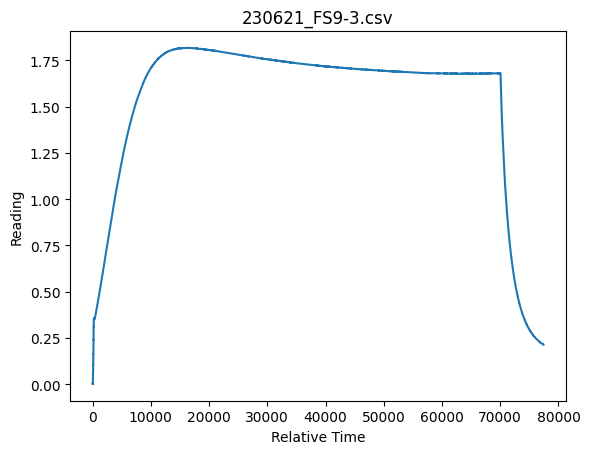

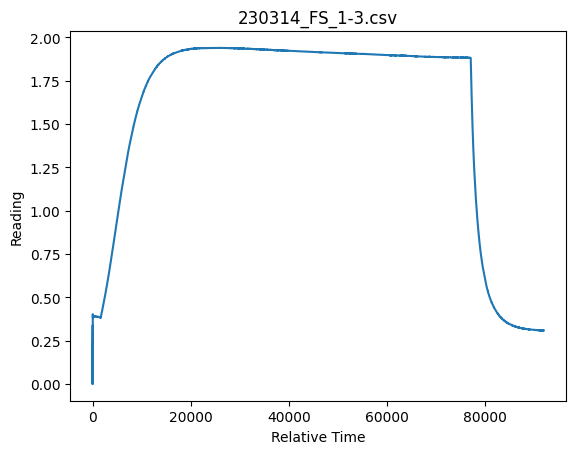

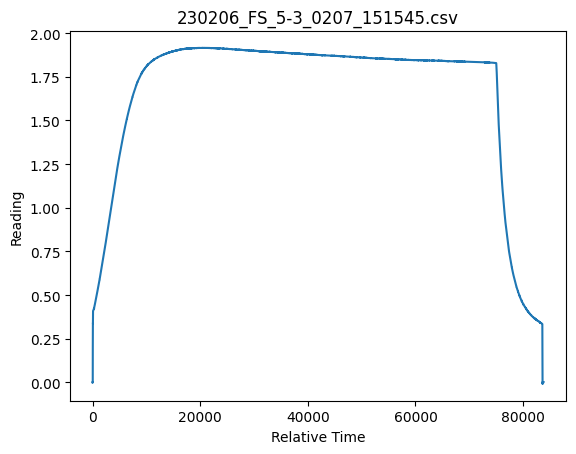

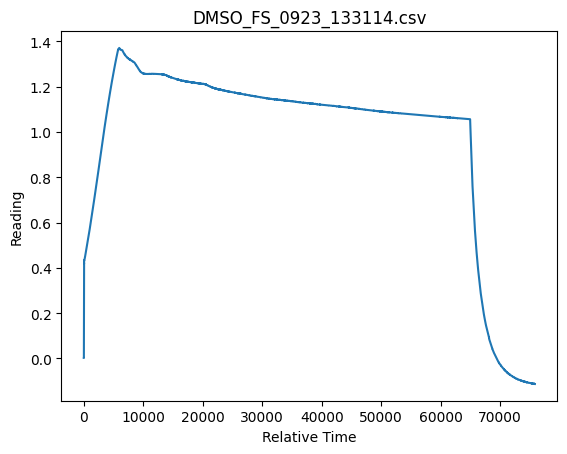

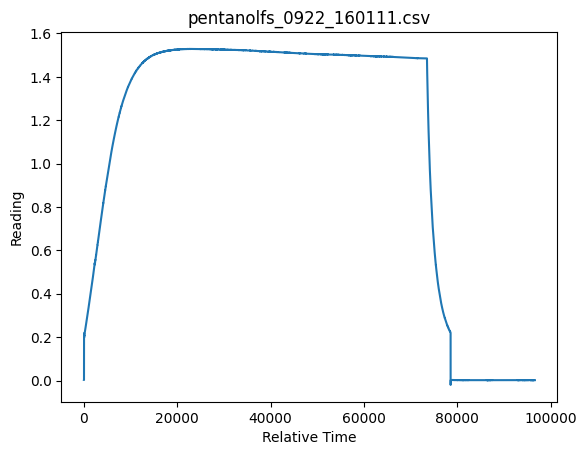

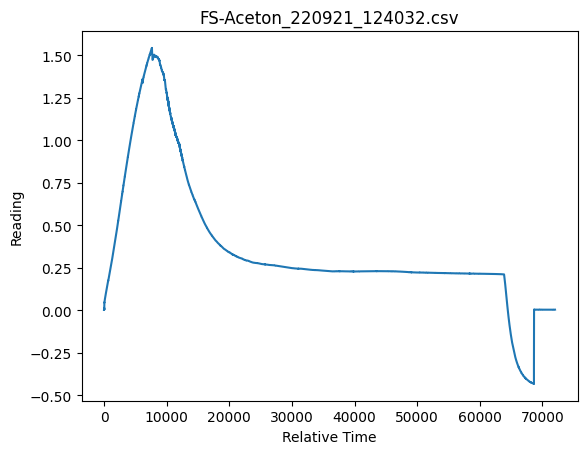

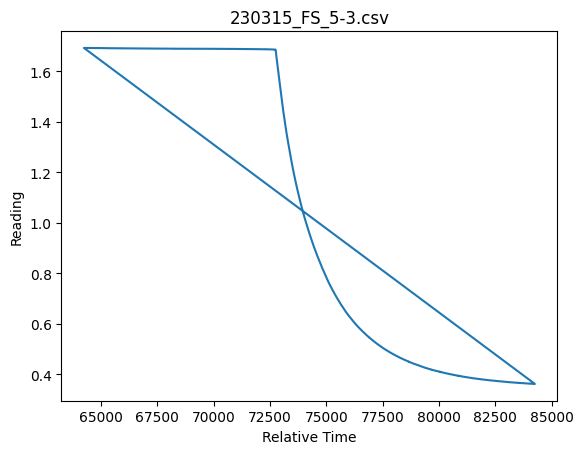

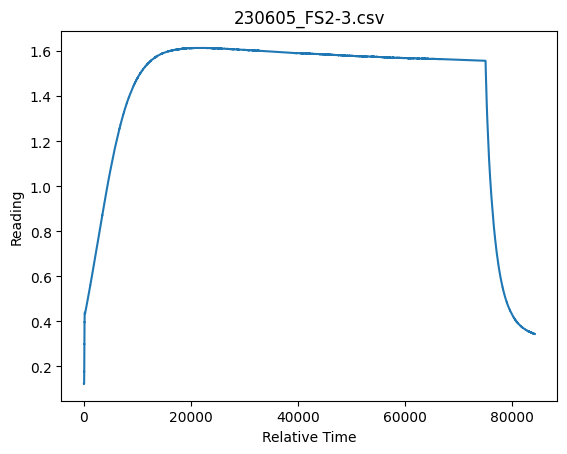

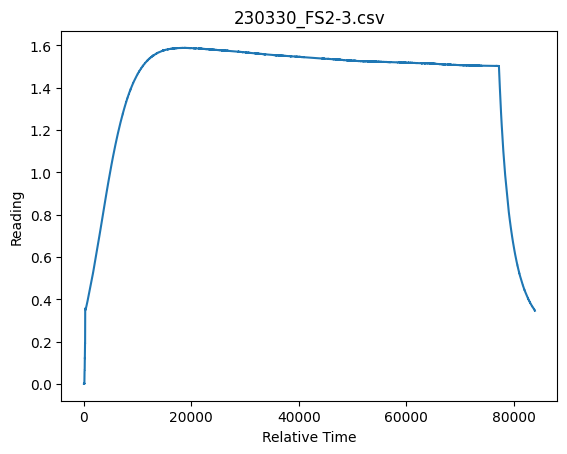

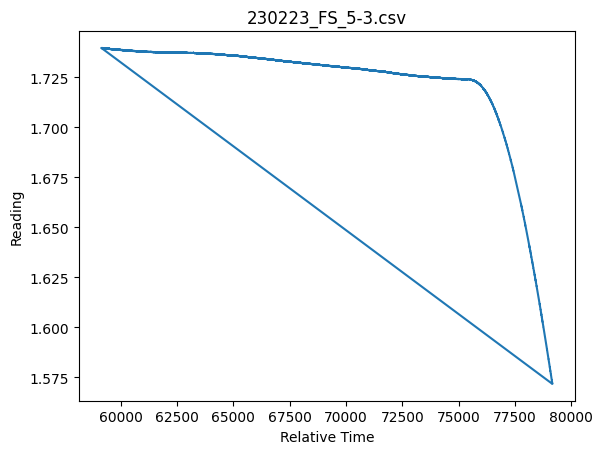

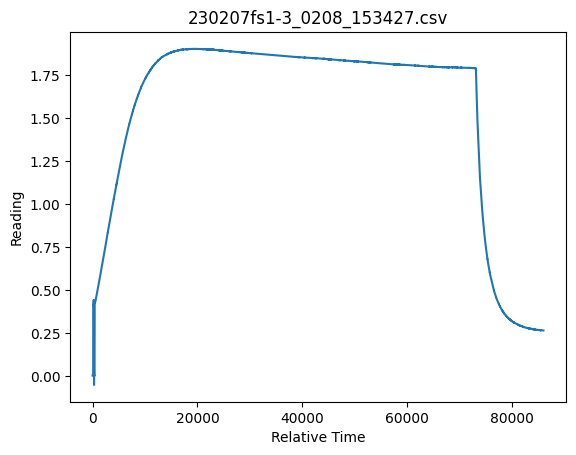

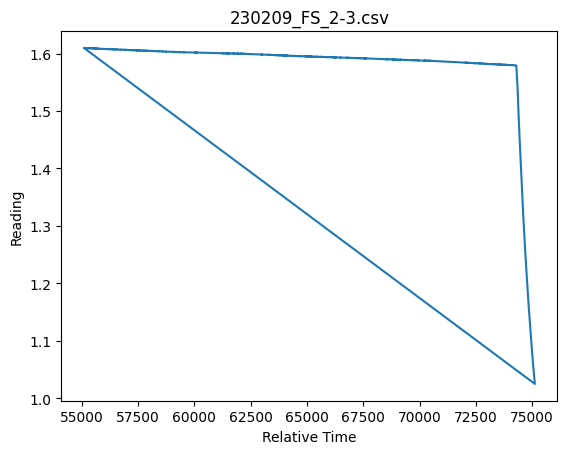

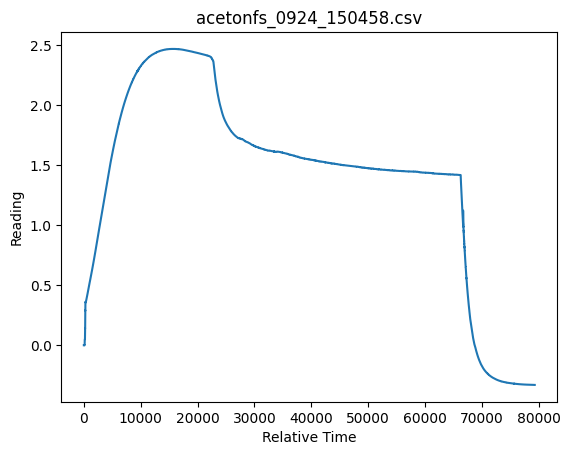

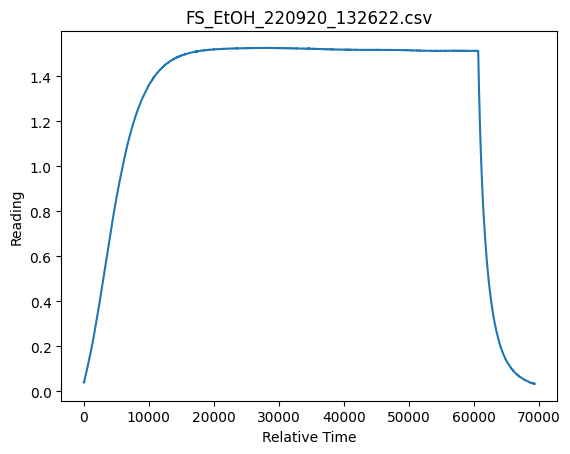

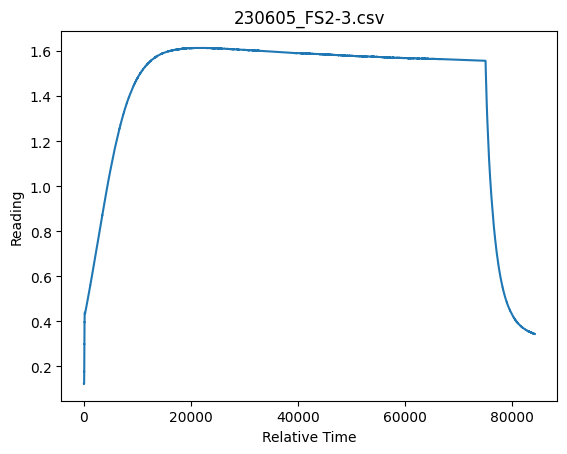

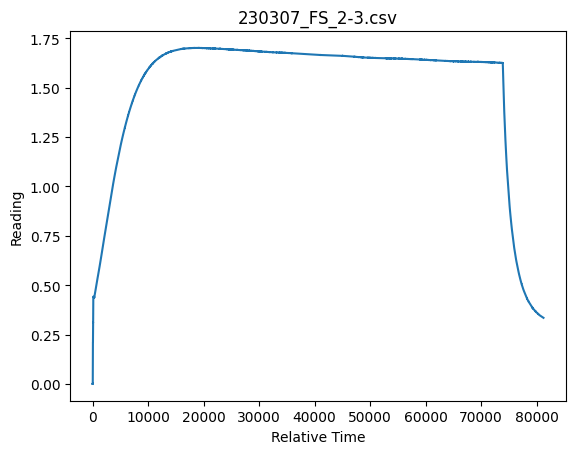

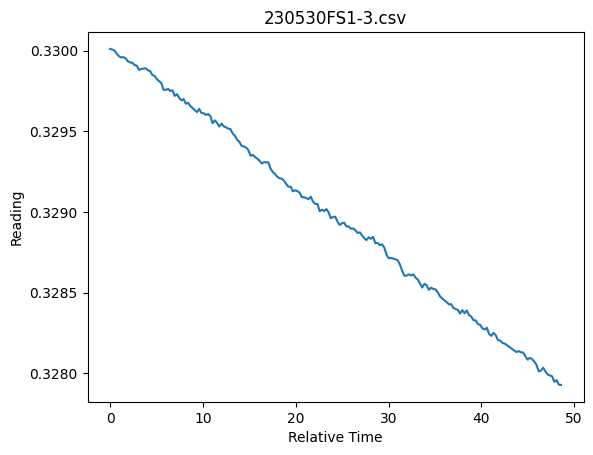

In [24]:
for filepath in file_list:
    try:
        # Read CSV or XLSX
        if filepath.lower().endswith(".csv"):
            df = pd.read_csv(filepath, sep=',', skiprows=8)  # adjust skiprows if needed
        else:
            df = pd.read_excel(filepath)

        # Optional: add experiment/file name
        df["Experiment"] = os.path.basename(filepath)

        # Example: plot (adjust column names as needed)
        plt.figure()
        plt.plot(df["Relative Time"], df["Reading"])
        plt.title(df["Experiment"].iloc[0])
        plt.xlabel("Relative Time")
        plt.ylabel("Reading")
        plt.show()

        # Clean up memory
        del df

    except Exception as e:
        print(f"❌ Error processing {filepath}: {e}")

## Cleaning the plots
We get the whole list of names from 'files found by os.walk'.
We then went through the list and split the plots into successful and unsuccessful experiments. The list are saved as separate textfiles.

Successful experiments:
- 230621_FS9-3.csv
- 230314_FS_1-3.csv
- 230206_FS_5-3_0207_151545.csv
- pentanolfs_0922_160111.csv
- 230605_FS2-3.csv
- 230330_FS2-3.csv
- 230207fs1-3_0208_153427.csv
- FS_EtOH_220920_132622.csv
- 230605_FS2-3.csv
- 230307_FS_2-3.csv
  
unsuccessful experiments:
- DMSO_FS_0923_133114.csv
- FS-Aceton_220921_124032.csv
- 230315_FS_5-3.csv
- 230223_FS_5-3.csv
- 230209_FS_2-3.csv
- acetonfs_0924_150458.csv
- 230530FS1-3.csv

In [25]:
#read text files, clean the names
with open("successful.txt") as f:
    successful_filenames = [line.strip() for line in f]  # removes whitespace and newlines
with open("unsuccessful.txt") as f:
    unsuccessful_filenames = [line.strip() for line in f]

successful_list = [f for f in file_list if os.path.basename(f) in successful_filenames]

unsuccessful_list  = [f for f in file_list if os.path.basename(f) in unsuccessful_filenames]


In [26]:
#define the plot: could be done in a funciton

def plot_group(file_list, title):
    plt.figure(figsize=(8,4))  # One figure for the whole group
    for filepath in file_list:
        try:
            # Read CSV or Excel
            if filepath.lower().endswith(".csv"):
                df = pd.read_csv(filepath, sep=',', skiprows=8)  # adjust skiprows if needed
            else:
                df = pd.read_excel(filepath)

            # Plot line with filename as label
            label = os.path.basename(filepath)
            plt.plot(df["Relative Time"], df["Reading"], label=label, alpha=0.8)

        except Exception as e:
            print(f"❌ Error processing {filepath}: {e}")

    plt.title(title)
    plt.xlabel("Relative Time")
    plt.ylabel("Reading")
    plt.legend(loc='lower center')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

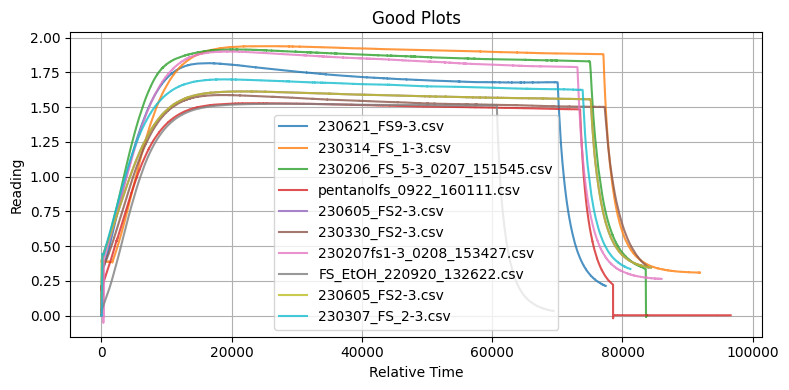

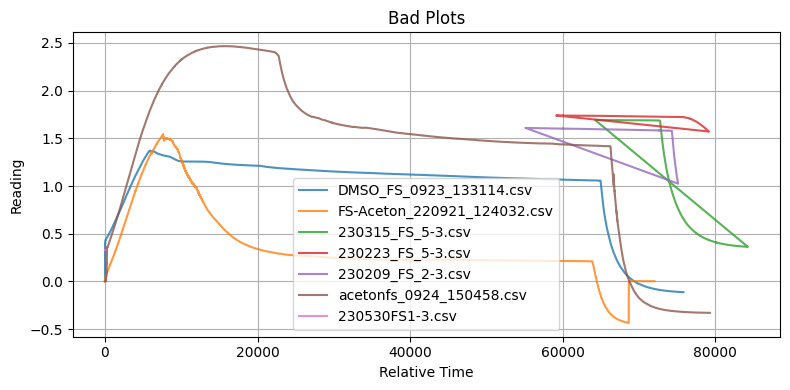

In [27]:
# Combined plot for successful files
plot_group(successful_list, "Good Plots")

# Combined plot for unsuccessful files
plot_group(unsuccessful_list, "Bad Plots")